<a href="https://colab.research.google.com/github/Nicordaro/MML/blob/main/MML_Thesis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Mathematics in Machine Learning
#Tesina
Nicolò Cordaro s272145

---



###Organize imports and dataset definition

In [1]:
import os
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Utility function to split dataset into train and test sets
from sklearn.model_selection import train_test_split    

In [2]:
# Clone github repository with dataset
# deleting if already present(Only for development purposes, colab limitations)
!rm -rf MML
!rm -rf dataset
if not os.path.isdir('./MML'):
  !git clone https://github.com/Nicordaro/MML
  
import shutil
    
source_dir = './MML/dataset'
target_dir = './dataset'
    
file_names = os.listdir(source_dir)
os.mkdir(target_dir)
for file_name in file_names:
  print(file_name)
  shutil.move(source_dir+"/"+file_name, target_dir+"/"+file_name)

Cloning into 'MML'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 19 (delta 2), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.
breast-cancer-wisconsin.data
breast-cancer-wisconsin.names


# Visualization

In [3]:
names = {"sampcode":"Sample code number", 
"clump": "Clump Thickness", 
"uni_size":"Uniformity of Cell Size", 
"uni_shape":"Uniformity of Cell Shape", 
"adhesion":"Marginal Adhesion", 
"epith_size":"Single Epithelial Cell Size", 
"nuclei":"Bare Nuclei", 
"chromatin":"Bland Chromatin", 
"nucleoli":"Normal Nucleoli", 
"mitoses":"Mitoses", 
"class":"Class"}


In [4]:
dataset_DF = pd.read_csv(target_dir+"/breast-cancer-wisconsin.data", names=list(names.keys()))
dataset_DF.iloc[:, 10] = dataset_DF.iloc[:, 10].replace(2, "benign").replace(4, "malign")
dataset_DF.dtypes

sampcode       int64
clump          int64
uni_size       int64
uni_shape      int64
adhesion       int64
epith_size     int64
nuclei        object
chromatin      int64
nucleoli       int64
mitoses        int64
class         object
dtype: object

In [5]:
dataset_DF.isin(['?']).any()

sampcode      False
clump         False
uni_size      False
uni_shape     False
adhesion      False
epith_size    False
nuclei         True
chromatin     False
nucleoli      False
mitoses       False
class         False
dtype: bool

In [6]:
delete_row = dataset_DF[dataset_DF["nuclei"]=="?"].index
dataset_DF = dataset_DF.drop(delete_row)
dataset_DF.isin(['?']).any()
dataset_DF.iloc[:, 6] = pd.to_numeric(dataset_DF.iloc[:, 6])

In [7]:
dataset_DF.dtypes

sampcode       int64
clump          int64
uni_size       int64
uni_shape      int64
adhesion       int64
epith_size     int64
nuclei         int64
chromatin      int64
nucleoli       int64
mitoses        int64
class         object
dtype: object

In [8]:
dataset_DF.head(7)

,sampcode,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,benign
1,1002945,5,4,4,5,7,10,3,2,1,benign
2,1015425,3,1,1,1,2,2,3,1,1,benign
3,1016277,6,8,8,1,3,4,3,7,1,benign
4,1017023,4,1,1,3,2,1,3,1,1,benign
5,1017122,8,10,10,8,7,10,9,7,1,malign
6,1018099,1,1,1,1,2,10,3,1,1,benign


In [9]:
datasetPurged = dataset_DF.drop("sampcode", axis=1)
datasetPurged.describe()

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


In [50]:
benignDF = datasetPurged.loc[datasetPurged['class'] == "benign"]
benignDF.describe()

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
count,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000,444.000000
mean,2.963964,1.306306,1.414414,1.346847,2.108108,1.346847,2.083333,1.261261,1.065315
std,1.672661,0.855657,0.957031,0.917088,0.877112,1.177848,1.062299,0.954606,0.509738
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000
50%,3.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000
75%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000
max,8.000000,9.000000,8.000000,10.000000,10.000000,10.000000,7.000000,8.000000,8.000000


In [51]:
malignDF = datasetPurged.loc[datasetPurged['class'] == "malign"]
malignDF.describe()

,clump,uni_size,uni_shape,adhesion,epith_size,nuclei,chromatin,nucleoli,mitoses
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,7.188285,6.577406,6.560669,5.585774,5.326360,7.627615,5.974895,5.857741,2.602510
std,2.437907,2.724244,2.569104,3.196631,2.443087,3.116679,2.282422,3.348876,2.564495
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.000000,4.000000,4.000000,3.000000,3.000000,5.000000,4.000000,3.000000,1.000000
50%,8.000000,6.000000,6.000000,5.000000,5.000000,10.000000,7.000000,6.000000,1.000000
75%,10.000000,10.000000,9.000000,8.000000,6.500000,10.000000,7.000000,9.500000,3.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


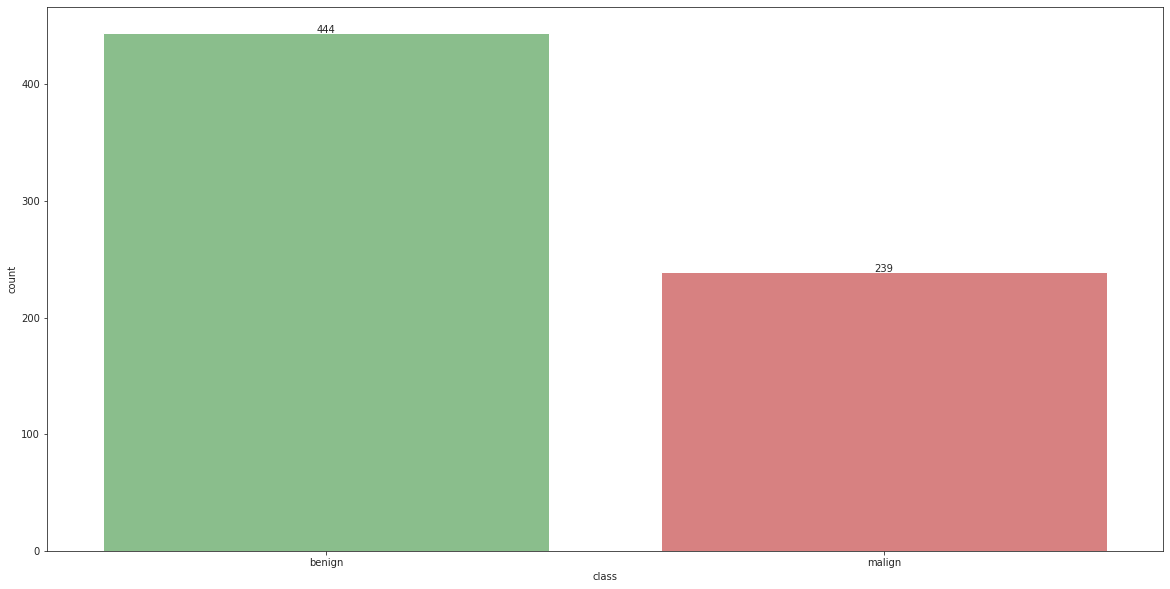

In [62]:
fig, ax1 = plt.subplots(figsize=(20,10))
graph = sns.countplot(dataset_DF.iloc[:,10], palette=col_dict);
graph.set_xticklabels(graph.get_xticklabels())
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center");

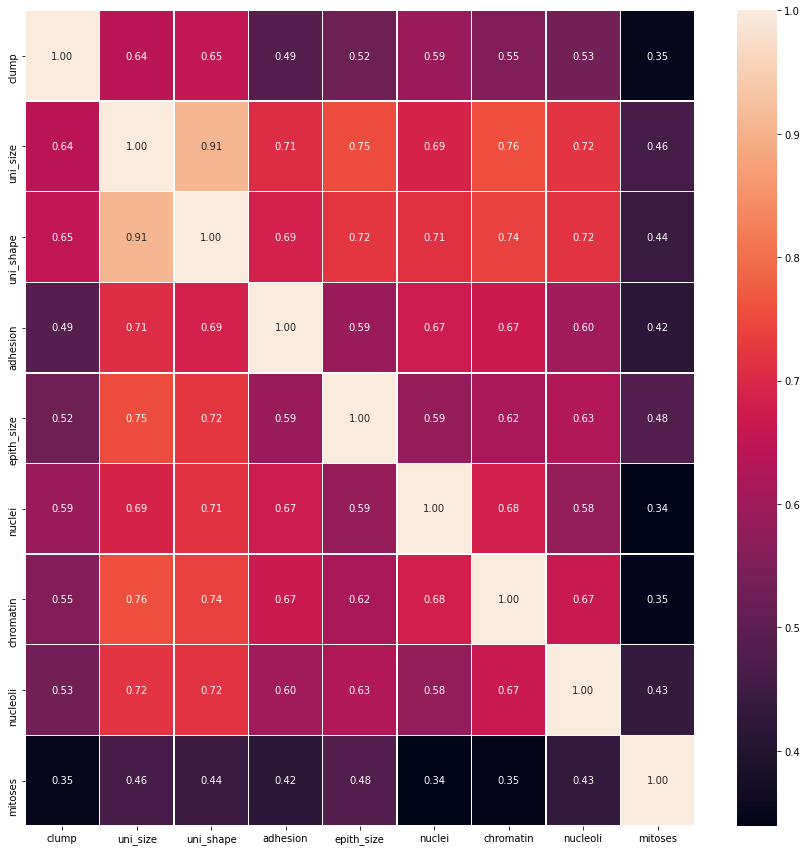

In [10]:
dataset_DF.corr()
corr = datasetPurged.corr()
f,ax = plt.subplots(figsize=(15,15), facecolor="white")
sns.heatmap(corr, annot=True, linewidths=0.5, fmt='.2f', ax=ax);

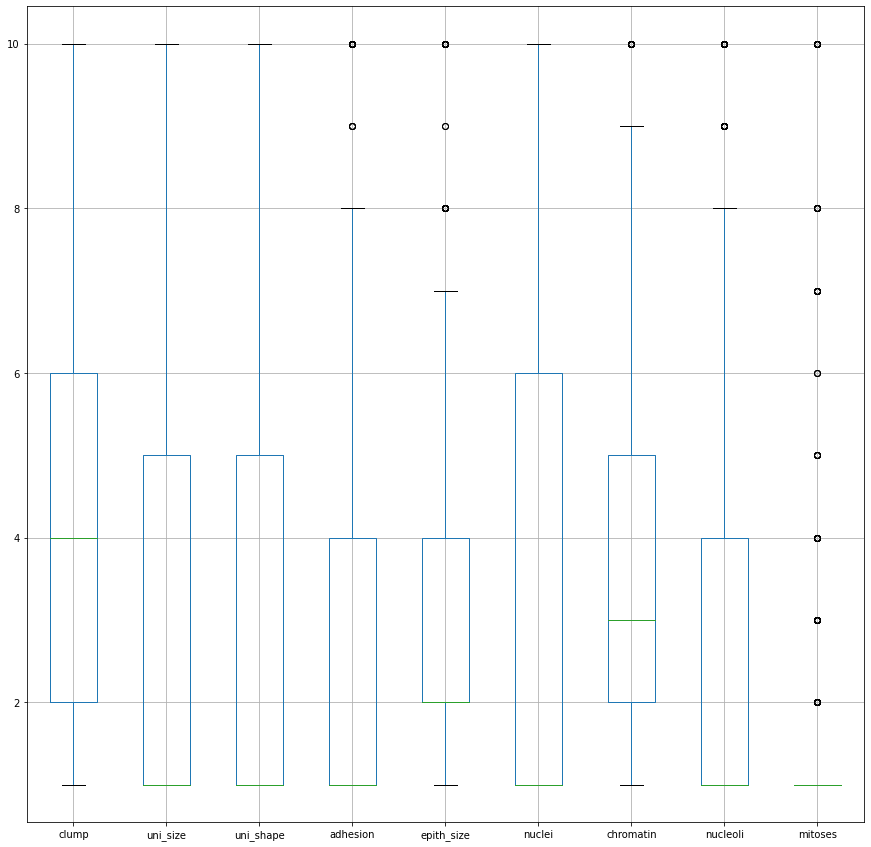

In [11]:
fig = plt.figure(figsize = (15,15), facecolor="white")
ax = fig.gca()
datasetPurged.boxplot(ax=ax);

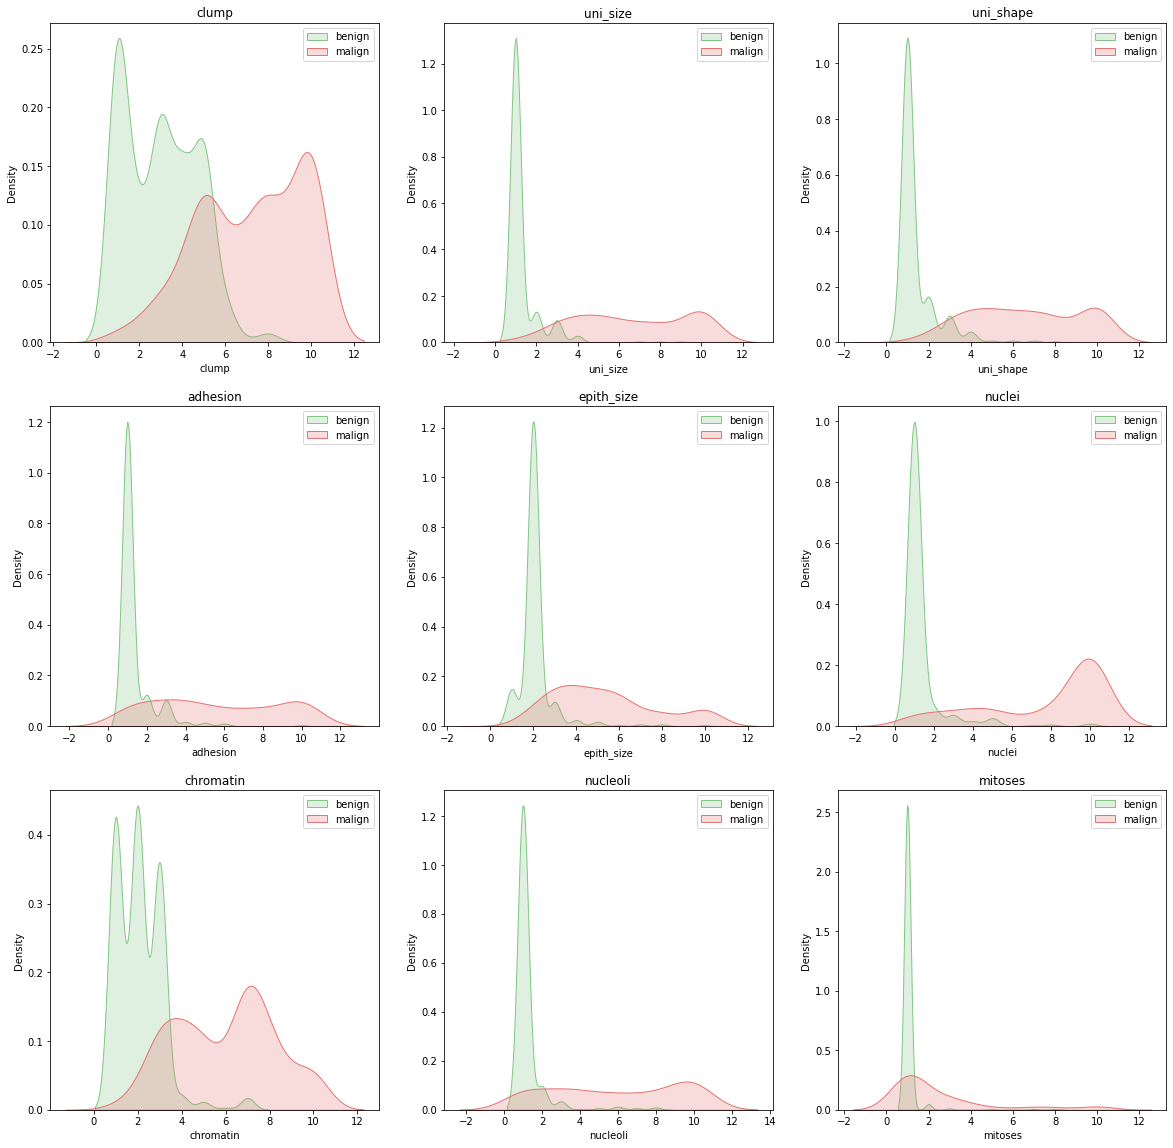

In [15]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")
for i, col in enumerate(datasetPurged.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.kdeplot(datasetPurged.loc[datasetPurged['class'] == 'benign', col], shade=True, fill = True, label='benign', color="#81c784")
  sns.kdeplot(datasetPurged.loc[datasetPurged['class'] == 'malign', col], shade=True, fill = True, label='malign', color="#e57373")
  plt.title(col)
  plt.legend(loc='upper right')

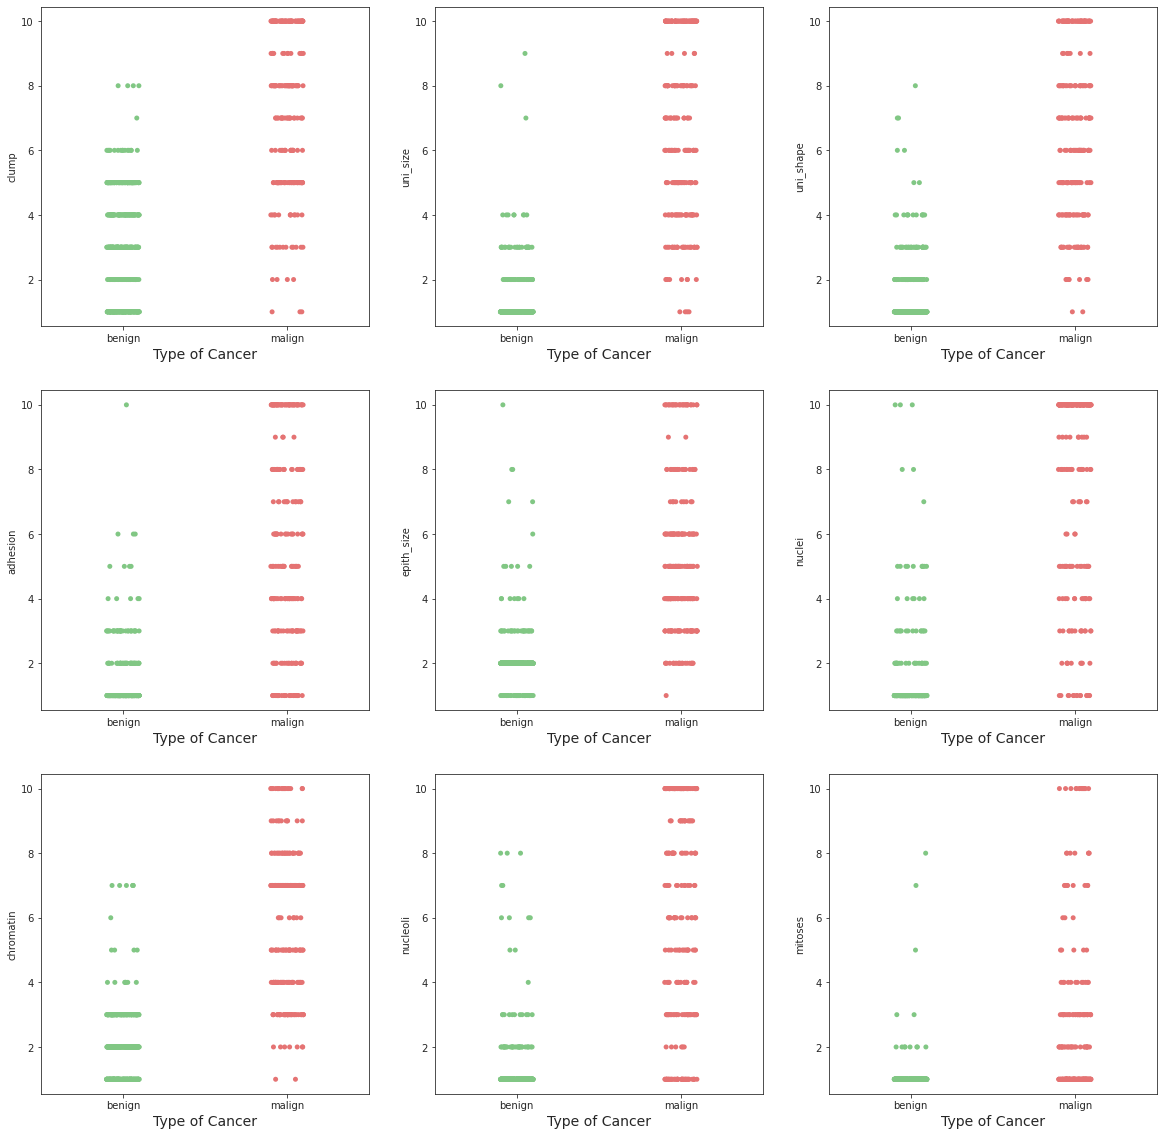

In [58]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")
for i, col in enumerate(datasetPurged.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.stripplot(y=datasetPurged.iloc[:, i] , x="class", palette=col_dict, data=datasetPurged)
  plt.xlabel("Type of Cancer", size=14)

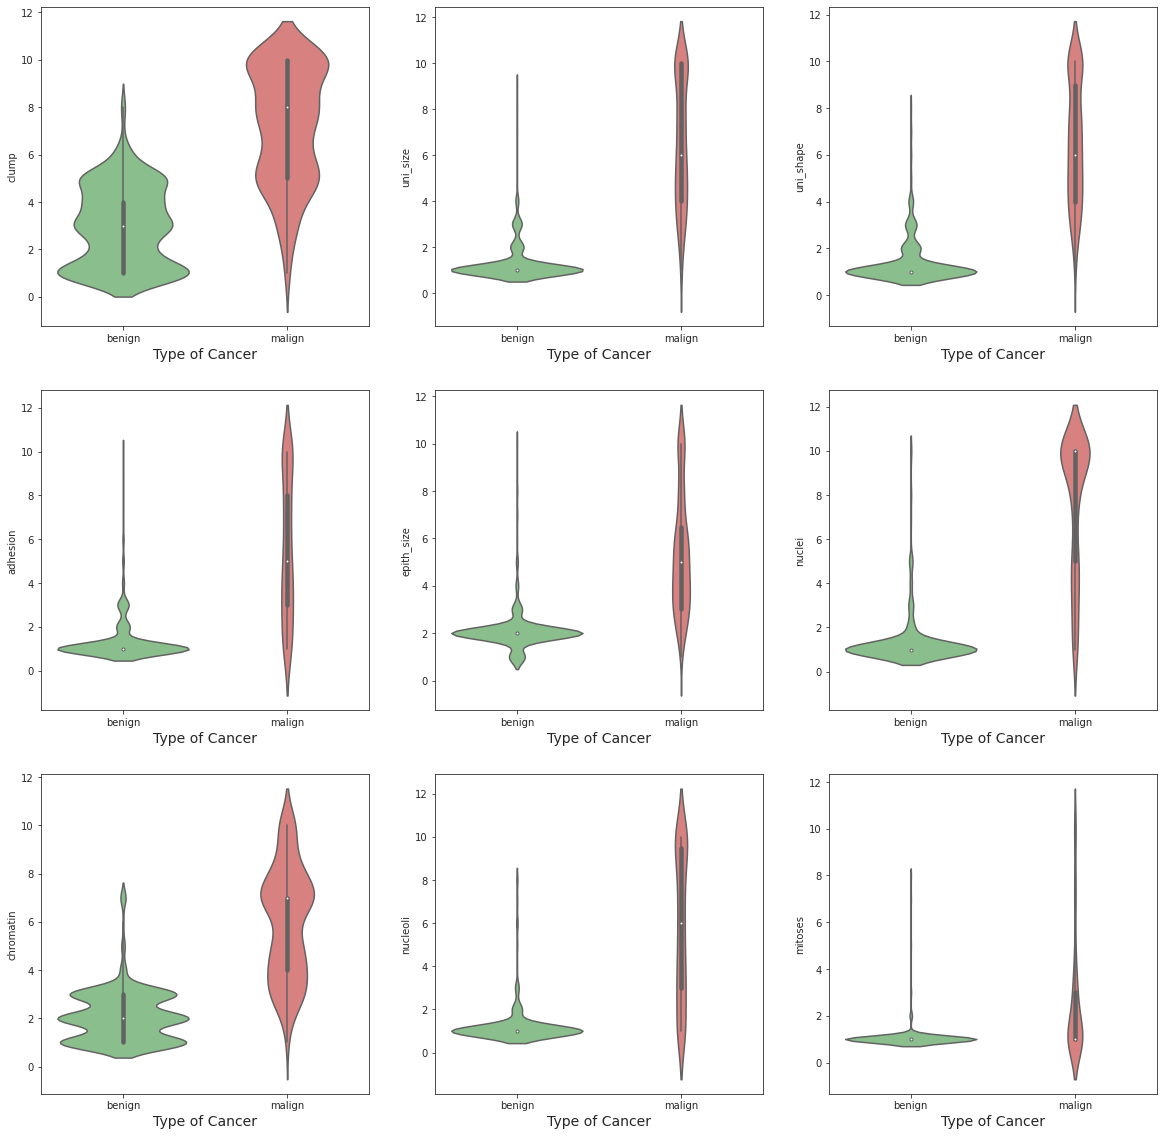

In [59]:
plt.subplots(3, 3, figsize = (20, 20), facecolor = "white")
for i, col in enumerate(datasetPurged.columns[:9]):
  plt.subplot(3, 3, i+1)
  sns.violinplot(y=datasetPurged.iloc[:, i] , x="class", palette=col_dict, data=datasetPurged)
  plt.xlabel("Type of Cancer", size=14)

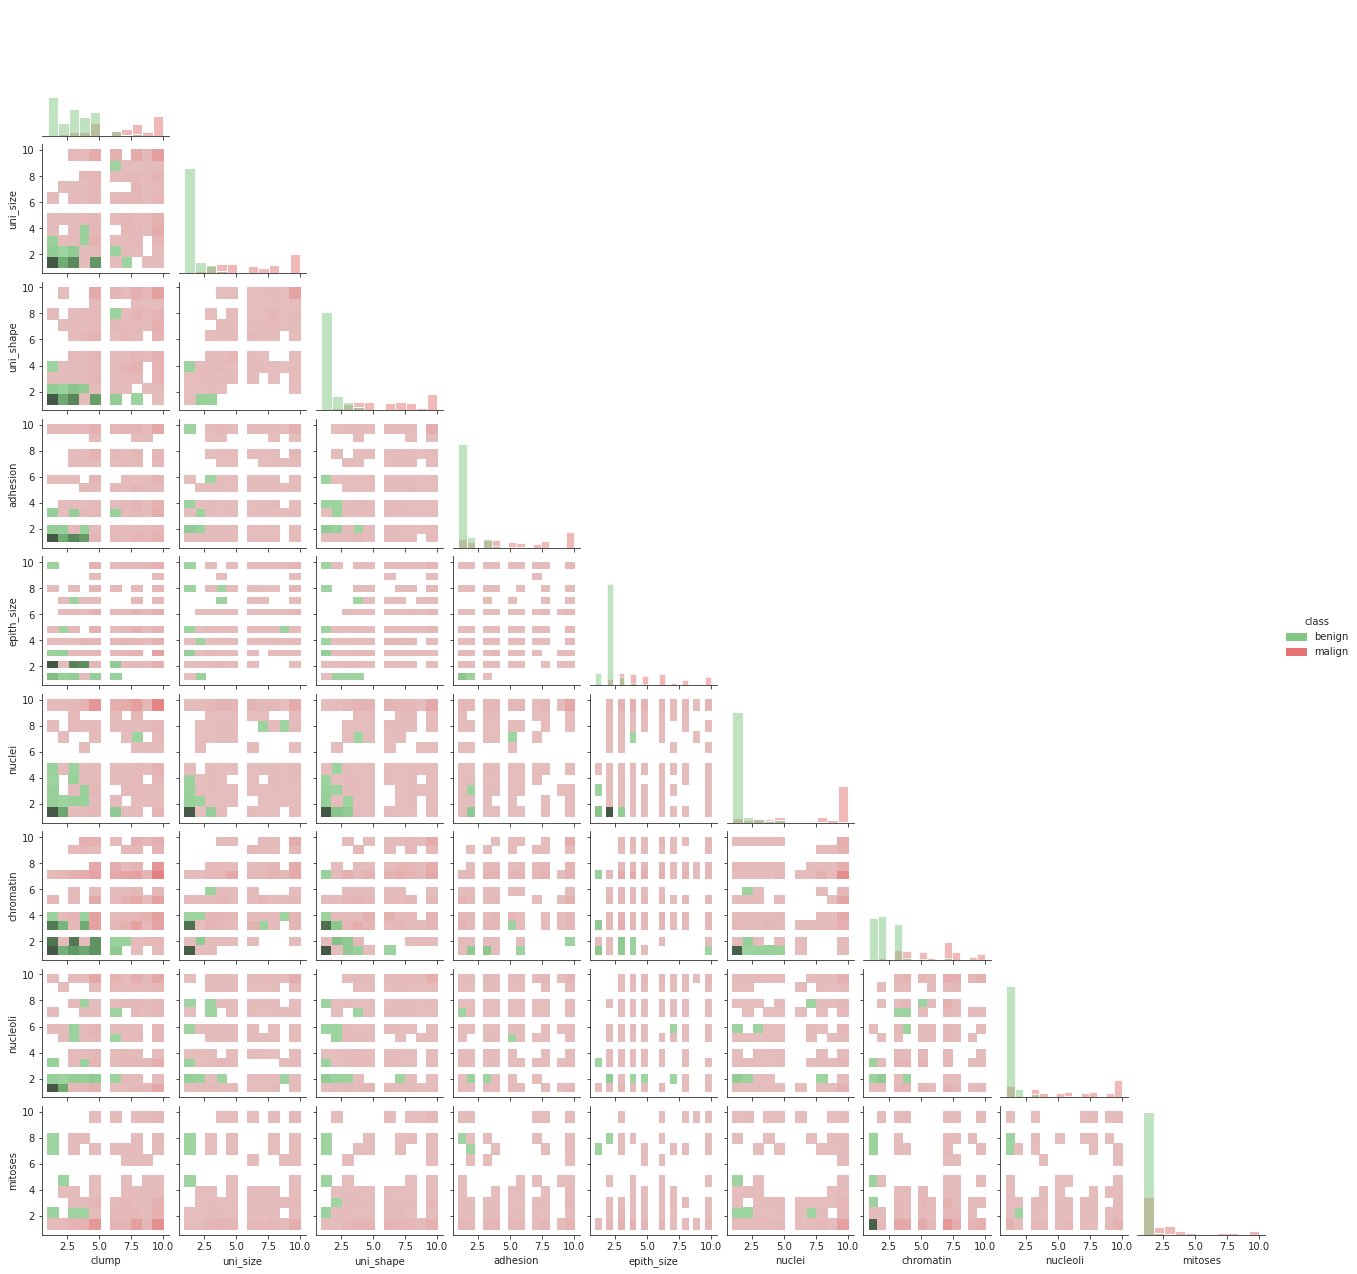

In [63]:
import seaborn as sns

df = dataset_DF.drop("sampcode", axis=1)
col_dict = {"benign":"#81c784", "malign": "#e57373"}
sns.set_style("ticks")

sns.pairplot(df, hue = "class", kind= "hist", diag_kind="hist", height=2, palette=col_dict, corner=True)
